# Analyzing the percentage of scheduled vs utilization

In [1]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def get_num(in_str: str, shorten=False):
    '''
    :param in_str:
    :return: just returns a single consecutive digit
    '''
    num = ""

    for s in in_str:
        if s.isdigit():
            num += s

    if shorten:
        num = num[:-1]
    return int(num)


## Getting Utilization per graph

In [2]:
util_dir = "../utilization/3-phase-data-ILP/"
util_dags = os.listdir(util_dir)

utils = {}
for dag in util_dags:
    if "DAG" not in dag:
        continue

    with open((os.path.join(util_dir, dag, "utilization.txt")), "r") as file:
        line = file.read().split(" ")
        utils[dag] = float(line[1])

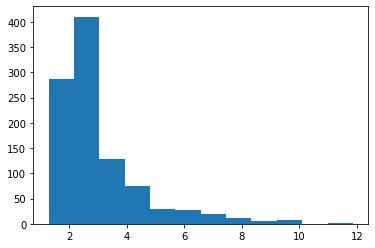

In [3]:
plt.hist(utils.values(), bins=12)
plt.show()

In [4]:
three_phase_dir = "../3-phase-data-ILP-out/"

three_phase_dags = os.listdir(three_phase_dir)
target_files = ["hFLS_output_005.txt"]

heuristic_scheduled = {}
heuristic_schedule_time = {}
ILP_scheduled = {}
ILP_schedule_time = {}

for dag in three_phase_dags:
    heuristic = float('inf')
    ilp = float('inf')
    heuristic_time =float('inf')
    ilp_time =float('inf')
    if "DAG" in dag and ".out" not in dag:
        file_path = os.path.join(three_phase_dir, dag, target_files[0])
        with open(file_path, "r") as file:
            for line in file:
                if "Makespan" in line:
                    heuristic = int(line.split(" ")[1])
                elif "Schedule time:" in line:
                    heuristic_time =  float(line.split(" ")[4])
            if heuristic == float('inf'):
                print(heuristic)
                # os.remove(crpd_20_path)
            heuristic_scheduled[dag]=heuristic
            heuristic_schedule_time[dag]=heuristic_time
    elif "DAG" in dag and ".out" in dag:
        file_path = os.path.join(three_phase_dir, dag)
        with open(file_path, "r") as file:
            for line in file:
                if "Final Schedule length" in line:
                    ilp = int(get_num(line.split(" ")[6]))/10
                elif "Schedule time:" in line:
                    ilp_time =  float(line.split(" ")[4])
                elif "not found in result" in line:
                    ilp = 999999
            if dag.find("_") == -1:
                dag_name = dag[:dag.find(".")]
            else:
                dag_name = dag[:dag.find("_")]
            ILP_scheduled[dag_name]=ilp
            ILP_schedule_time[dag_name]=ilp_time

inf


In [5]:
three_phase_dir = "../3-phase-data-ILP/"

three_phase_dags = os.listdir(three_phase_dir)
target_files = [".tey"]

deadlines = {}

for dag in three_phase_dags:
    heuristic = float('inf')
    if "DAG" not in dag:
        continue

    for tf in target_files:
        file_path = os.path.join(three_phase_dir, dag, dag + tf)
        with open(file_path, "r") as file:
            for line in file:
                if "period" in line:
                    deadline = get_num(line)
                    break

    deadlines[dag]=deadline

In [6]:
three_phase_dir = "../3-phase-data-ILP/"

three_phase_dags = os.listdir(three_phase_dir)
target_files = [".tey"]

num_tasks = {}

for dag in three_phase_dags:
    heuristic = float('inf')
    if "DAG" not in dag:
        continue

    dag_num = dag[3:]
    tasks = 0
    # print(dag_num)

    for tf in target_files:
        file_path = os.path.join(three_phase_dir, dag, dag + tf)
        with open(file_path, "r") as file:
            for line in file:
                if "t" + str(dag_num) in line and "out" not in line:
                    task_num = int(line[line.find("_")+1: line.find(" ")])
                    tasks = max(tasks, task_num)
                    # print(line, task_num, tasks)

        num_tasks[dag] = tasks + 1

In [7]:
combined = [heuristic_scheduled, heuristic_schedule_time, ILP_scheduled, ILP_schedule_time, deadlines, utils, num_tasks]
scheduled = {}

for k in heuristic_scheduled.keys():
    scheduled[k] = list(d[k] for d in combined)

    # scheduled[dag] = [crpd_0, crpd_1, crpd_5, crpd_10, crpd_15, crpd_20, single_FLS, deadline]

In [8]:
# merged_dict = {}
# for k in utils.keys():
#     merged_dict[k] = scheduled[k]
#     merged_dict[k].append(utils[k])

In [9]:
df = pd.DataFrame.from_dict(scheduled, orient='index', columns=['heuristic', 'heuristic_time', 'ILP', 'ILP_time', 'Deadline', 'Utilization', 'number_tasks'])

In [10]:
print(sum(df['heuristic'] <= df['Deadline']))
print(sum(df['ILP'] <= df['Deadline']))


536
356


In [11]:
# Check if there are any graphs where hFLS finds a schedule and ILP does not
check_hFLS_wrong = df[df["ILP"] == 999999]
print(check_hFLS_wrong['heuristic'][check_hFLS_wrong['heuristic'] <= check_hFLS_wrong['Deadline']])
print(check_hFLS_wrong['Deadline'][check_hFLS_wrong['heuristic'] <= check_hFLS_wrong['Deadline']])


Series([], Name: heuristic, dtype: float64)
Series([], Name: Deadline, dtype: int64)


In [12]:
# df_copy = df
# df['Deadline']= df_copy['Deadline']*1.2
# df['Utilization']= df_copy['Utilization']*(1/1.2)

In [13]:
bins = range(1,8,1)

bin_data_heuristic = {}
bin_data_ILP = {}
bin_size = {}

for bin in bins:
    # Last Bin
    if bin == bins[-1]:
        bin_selection = (df["Utilization"] > (bin - 1))
    else:
        bin_selection =  (bin >= df["Utilization"]) & (df["Utilization"] > (bin - 1))
    selected_data = df[bin_selection]
    if selected_data.empty:
        continue

    success_heuristic = 0
    success_ILP = 0
    bin_size[bin] = len(selected_data["heuristic"].tolist())

    for makespan, time, deadline in zip(selected_data["heuristic"].tolist(), selected_data["heuristic_time"].tolist(), selected_data["Deadline"].tolist()):
        if makespan <= deadline:
            success_heuristic += 1

    for makespan, time, deadline, index in zip(selected_data["ILP"].tolist(), selected_data["ILP_time"].tolist(), selected_data["Deadline"].tolist(), selected_data.index.tolist()):
        if makespan <= deadline:
            success_ILP += 1

    correct_heuristic = success_heuristic/ len(selected_data["heuristic"].tolist())
    bin_data_heuristic[bin] = correct_heuristic
    # bin_time_heuristic[bin] = np.mean(makespan_time)

    correct_ILP = success_ILP/ len(selected_data["ILP"].tolist())
    bin_data_ILP[bin] = correct_ILP
    # bin_time_ILP[bin] = np.mean(ILP_time)


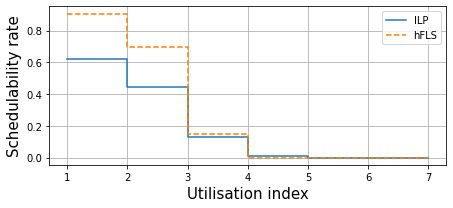

In [14]:
# All results
fig, ax = plt.subplots(figsize=(6.4, 3.0))

ax.set_xlabel("Utilisation index", fontsize=15)
ax.set_ylabel("Schedulability rate", fontsize=15)

# plt.xticks(bins,[u"≤1", "≤2", "≤3", "≤4", "≤5", "≤6", "≤7",], fontsize=10)

keys = [1,2,2,3,3,4,4,5,5,6,6,7]

values_ilp = []
for v in bin_data_ILP.values():
    values_ilp += [v,v]

values_multi = []
for v in bin_data_heuristic.values():
    values_multi += [v,v]

ax.plot(keys, values_ilp, label="ILP")
ax.plot(keys, values_multi,'--', label="hFLS")

# ax.plot(bin_data_ILP.keys(), bin_data_ILP.values(), label="ILP")
# ax.scatter(bin_data_ILP.keys(), bin_data_ILP.values())
#
# ax.plot(bin_data_heuristic.keys(), bin_data_heuristic.values(), '--', label="hFLS")
# ax.scatter(bin_data_heuristic.keys(), bin_data_heuristic.values())


ax.grid()

ax.legend()
fig.tight_layout()
plt.savefig("hFLS_vs_ILP.pdf", dpi=600)
plt.show()

In [15]:
# Only graphs where ILP found a solution
bins = range(1,8,1)

bin_data_heuristic = {}
bin_data_ILP = {}
bin_size = {}

for bin in bins:
    # Last Bin
    if bin == bins[-1]:
        bin_selection = (df["Utilization"] > (bin - 1))
    else:
        bin_selection =  (bin >= df["Utilization"]) & (df["Utilization"] > (bin - 1))
    selected_data = df[bin_selection]
    selected_data = selected_data[selected_data["ILP"] != float('inf')]
    if selected_data.empty:
        continue

    success_heuristic = 0
    success_ILP = 0
    bin_size[bin] = len(selected_data["heuristic"].tolist())

    for makespan, time, deadline in zip(selected_data["heuristic"].tolist(), selected_data["heuristic_time"].tolist(), selected_data["Deadline"].tolist()):
        if makespan <= deadline:
            success_heuristic += 1

    for makespan, time, deadline, index in zip(selected_data["ILP"].tolist(), selected_data["ILP_time"].tolist(), selected_data["Deadline"].tolist(), selected_data.index.tolist()):
        if makespan <= deadline:
            success_ILP += 1

    correct_heuristic = success_heuristic/ len(selected_data["heuristic"].tolist())
    bin_data_heuristic[bin] = correct_heuristic
    # bin_time_heuristic[bin] = np.mean(makespan_time)

    correct_ILP = success_ILP/ len(selected_data["ILP"].tolist())
    bin_data_ILP[bin] = correct_ILP
    # bin_time_ILP[bin] = np.mean(ILP_time)

In [16]:
test = df["ILP"] <= df["Deadline"]
print(sum(test))
test = df["ILP"] != float('inf')
print(sum(test))
test = df[df["ILP"] != float('inf')]
test = test["heuristic"] <= test["Deadline"]
print(sum(test))

356
788
337


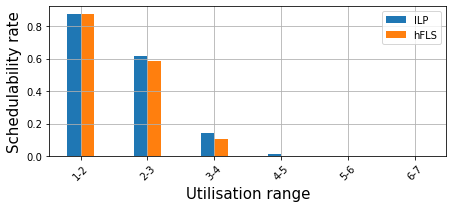

In [21]:
# Only graphs where ILP found a solution

fig, ax = plt.subplots(figsize=(6.4, 3.0))

ax.set_xlabel("Utilisation range", fontsize=15)
ax.set_ylabel("Schedulability rate", fontsize=15)

# plt.xticks(bins,[u"≤1", "≤2", "≤3", "≤4", "≤5", "≤6", "≤7",], fontsize=10)

# keys = [1,2,2,3,3,4,4,5,5,6,6,7]


bin_ticks = [1.5,2.5,3.5,4.5,5.5,6.5]

# plt.xticks(bins,["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15"], fontsize=10)
plt.xticks(bin_ticks,["1-2", "2-3", "3-4", "4-5", "5-6", "6-7"], fontsize=10, rotation=45)
# plt.xticks(bins,["≤1", "≤2", "≤3", "≤4", "≤5", "≤6", "≤7", "≤8", "≤9", "≤10", "10<"], fontsize=10)

values_ilp = []
for v in bin_data_ILP.values():
    # values_ilp += [v,v]
    values_ilp += [v]

values_multi = []
for v in bin_data_heuristic.values():
    # values_multi += [v,v]
    values_multi += [v]

keys1 = [1.3,2.3,3.3,4.3,5.3,6.3]
keys2 = [1.5,2.5,3.5,4.5,5.5,6.5]

# ax.plot(keys, values_ilp, label="ILP")
# ax.plot(keys, values_multi,'--', label="hFLS")

ax.bar(keys1, values_ilp, 0.2, label="ILP", align='edge')
ax.bar(keys2, values_multi, 0.2, label="hFLS", align='edge')

# ax.plot(bin_data_ILP.keys(), bin_data_ILP.values(), label="ILP")
# ax.scatter(bin_data_ILP.keys(), bin_data_ILP.values())
#
# ax.plot(bin_data_heuristic.keys(), bin_data_heuristic.values(), '--', label="hFLS")
# ax.scatter(bin_data_heuristic.keys(), bin_data_heuristic.values())


ax.grid()

ax.legend()
fig.tight_layout()
plt.savefig("hFLS_vs_ILP.pdf", dpi=600)
plt.show()


In [18]:
fig, ax = plt.subplots(figsize=(6.4, 3.0))

ax.set_xlabel("Number of Tasks", fontsize=15)
ax.set_ylabel("Scheduling time", fontsize=15)


selected=df[df['ILP'] <= df['Deadline']]
ax.scatter(selected['number_tasks'], selected['ILP_time'], label="ILP")
selected=df[df['heuristic'] <= df['Deadline']]
ax.scatter(selected['number_tasks'], selected['heuristic_time'], label="hFLS")

ax.grid()

ax.legend()
fig.tight_layout()
plt.savefig("hFLS_vs_ILP_scheduling_time.pdf", dpi=600)
plt.show()


In [17]:
three_phase_dir = "../3-phase-data-ILP-out/"

three_phase_dags = os.listdir(three_phase_dir)
target_files = ["hFLS_output_005.txt"]

time_constraint = 0
memory_constraint = 0

for dag in three_phase_dags:
    if "DAG" in dag and ".out" in dag:
        file_path = os.path.join(three_phase_dir, dag)
        with open(file_path, "r") as file:
            for line in file:
                if "CPLEX Error  1217: No solution exists." in line:
                    time_constraint += 1
                elif "CPLEX Error  1001: Out of memory." in line:
                    memory_constraint += 1

print(time_constraint/1000)
print(memory_constraint/1000)


0.013
0.192


In [20]:
num_i = []
num_h = []
for i, h, s in zip(bin_data_ILP.values(), bin_data_heuristic.values(), bin_size.values()):
    num_i.append(i * s)
    num_h.append(h * s)

    # diff += (num_h - num_i)

In [21]:
sum(num_h) - sum(num_i)


180.0